# WNBA Lottery Simulator

Once the season concludes, the WNBA lottery odds are determined. However, once the lottery draft order is revealed in reverse, the odds do not get updated. This would be especially interesting when a team is "skipped", meaning that teams are no longer picking in reverse order of record in the past two seasons. 

This notebook contains an introduction to the `image` endpoint of the API through the `Logo` class in the `py_ball` package to add some aesthetic appeal to the live-odds calculator.

In [8]:
import glob
from io import BytesIO
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
import base64
from IPython.display import display, HTML
from IPython.display import clear_output
import time

from py_ball import image

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The first step is to write a function that calculates the odds of selecting in any lottery slot given the number of teams that have not been selected, the corresponding number of chances remaining, and the teams that have been selected.

In [9]:
def calculate_pick_probabilities(lotto_combos, top_picks, teams_selected, top_pick_list, top_pick_order):
    """ calculate_pick_probabilities dynamically calculates the probability of each
    team receiving picks 1-4 in the WNBA Lottery.

    @param lotto_combos (dict): Dictionary keyed by team
        lottery order with values corresponding to each team's
        lottery chances
    @param top_picks (int): Integer indicating the number of
        picks that are selected via the lottery. The rest of the
        picks are slotted in reverse order of team record
    @param teams_selected (list): List containing the team lottery
        order of teams already revealed in the lottery and not in
        the top_picks number of picks
    @param top_pick_list (list): List containing the team lottery
        order of teams already revealed to be in the top_picks number
        of picks
    @param top_pick_order (list): List containing the order of the
        top picks as they are revealed

    Returns:

        prob_dict (dict): Dictionoary keyed by team lottery order
            with a list containing the probability of the team
            receiving each draft pick
    """

    prob_dict = {}
    total_teams = len(lotto_combos)
    total_combos = 0
    for num in lotto_combos:
        if num not in teams_selected:  # Only adding teams that have not been revealed
            total_combos += lotto_combos[num]

    team_list = list(lotto_combos.keys())
    for team in range(1, total_teams + 1):
        prob_list = [0] * total_teams # Initializing the list of pick probabilities                      
        if team in teams_selected and team not in top_pick_order:
            fall_spot = 0
            for top_pick in top_pick_list:
                if top_pick > team:
                    fall_spot += 1
            prob_list[team - 1 + fall_spot] = 1 # If a team has been revealed, we know with certainty the pick number
        elif team in top_pick_order:
            count = 0
            for team_here in top_pick_order:
                if team_here == team:
                    prob_list[top_picks - count - 1] = 1
                count += 1
        else:
            pick_order = list(itertools.permutations(team_list,
                                                     top_picks - len(top_pick_order)))
            prob_fall = [0] * (top_picks + 1)

            # If a team has not been revealed, we loop through all possible permutations of the
            # first four picks and find the probability of each permutation occurring
            for order in pick_order:
                balls_remaining = total_combos
                other_teams_probability = 1
                top_pick_probability = 1

                # If a team has been revealed to be in the top number of picks, only permutations
                # containing that team are valid. top_pick_ind ensures that only these permutations
                # are evaluated
                top_pick_ind = 1
                for top_pick in top_pick_list:
                    if top_pick in order or top_pick in teams_selected:
                        top_pick_ind *= 1
                    else:
                        top_pick_ind *= 0

                if top_pick_ind:
                    fall_spots = 0
                    pick_ind = 0
                    count = 0
                    for pick in order:
                        if pick in teams_selected:
                            # If a pick has already been revealed to be outside of the
                            # top picks, this permutation is invalid
                            other_teams_probability = 0
                            top_pick_probability = 0
                            break

                        if team in order:
                            # If team is in this permutation of top picks, evaluate the probability
                            # of the permutation occurring AND track the pick number with the pick_count
                            # index.
                            if pick == team:
                                pick_count = count
                            other_teams_probability = 0
                            shot_prob = lotto_combos[pick]/float(balls_remaining)

                            balls_remaining = balls_remaining - lotto_combos[pick]
                            top_pick_probability *= shot_prob
                            pick_ind = 1
                            count += 1
                        else:
                            # If team is not in this permutation, track the number of teams higher
                            # than the current team that are in the permutation. This gives the number
                            # of spots that the team falls in the lottery. Again, track the probability
                            # of this permutation occurring AND track the pick number with the fall_spots
                            # index
                            pick_ind = 0
                            if pick > team:
                                fall_spots += 1

                            shot_prob = lotto_combos[pick]/float(balls_remaining)

                            balls_remaining = balls_remaining - lotto_combos[pick]

                            count += 1

                            other_teams_probability *= shot_prob

                    # If pick_ind == 0, the team does not pick in the top_picks in this permutation
                    # If pick_ind == 1, the team does pick in the top_picks in this permutation
                    if pick_ind == 0:
                        prob_fall[fall_spots] += \
                            other_teams_probability
                    else:
                        prob_list[pick_count] += \
                            top_pick_probability

            # This loop fills in the corresponding "fall" spot with the appropriate probability
            for spot in range(team - 1, team + top_picks - len(top_pick_order)):
                if spot <= total_teams - 1 and spot > top_picks - 1:
                    prob_list[spot] = prob_fall[spot - team + 1]

        prob_list = [x/sum(prob_list) for x in prob_list]
        prob_dict[team] = [round(100*x, 1) for x in prob_list]

    return prob_dict

The WNBA lottery is conducted by selecting 4 out of 1,000 balls that are numbered 1-14. Each team is assigned a number of these 4-number combinations. Here are the number of combinations by team for the 2020 WNBA Draft Lottery ([source](https://pr.nba.com/wnba-draft-lottery-2020-presented-by-state-farm-to-take-place-sept-17-on-espn2/)):

- New York Libery: 442 combinations
- Indiana Fever: 276 combinations
- Dallas Wings: 178 combinations
- Atlanta Dream: 104 combinations

Only the top two teams are selected via this process, with the remainder of the teams selecting in reverse order of the team record for the past two seasons.

In [10]:
lottery_info = {1: {'name': 'Liberty', 'id': '1611661313'},
                2: {'name': 'Fever', 'id': '1611661325'},
                3: {'name': 'Wings', 'id': '1611661321'},
                4: {'name': 'Dream', 'id': '1611661330'}}

for lotto in lottery_info:
    
    team_logo = image.Logo(league='WNBA',
                           team_id=lottery_info[lotto]['id'])
    lottery_info[lotto]['logo'] = team_logo.image

## Instructions

1. Tune into the WNBA Draft Lottery on Tuesday, September 17th!
2. As picks are revealed, fill in the pick order of the pick that is revealed. For example, if the Dream are revealed first, add the 4 to the teams_selected list below.
3. If a pick is "skipped" (an expected team is jumped over in the revealing process), add the integer of that team to the top_pick_list list below.
4. Once the first 2 picks are revealed, the top_pick_list should contain 2 teams. As the final two teams are revealed, add the integer of that team to both the teams_selected_list and top_pick_order list
5. Throughout this entire process, run all cells below in order to show the updated live odds!

### Example

Consider the following draft order (starting with pick 4):
- Wings
- Fever
- Liberty
- Dream

One would fill in the lists from left to right accordingly
- `teams_selected = [3, 2, 1, 4]`
- `top_pick_list = [4, 1]`
- `top_pick_order = [1, 4]`

In [66]:
lotto_chances = {1: 442, 2: 276,
                 3: 178, 4: 104}

top_picks = 2
teams_selected = [4, 2]
top_pick_list = [3, 1] # Gets filled in with top picks as they are "revealed"
top_pick_order = [] # Ordered list of length top_picks, first index is the highest possible pick

prob_dict = calculate_pick_probabilities(lotto_chances, top_picks, teams_selected, top_pick_list, top_pick_order)

In [67]:
lotto_df = pd.DataFrame(prob_dict)

lotto_df.columns = [lottery_info[x]['name'] for x in prob_dict]

lotto_df = lotto_df.T
lotto_df.columns = list(range(1, len(lotto_chances) + 1))

In [68]:
pd.set_option('display.max_colwidth', -1)

def get_thumbnail(i):
    i.thumbnail((50, 50), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}" height="42" width="42">'


image_list = []
for lotto in lottery_info:
    image_list.append(image_formatter(lottery_info[lotto]['logo']))
lotto_df['logo'] = image_list

lotto_df = lotto_df.sort_values([1, 2],
                                ascending=[False, False])

,1,2,3,4,logo
Liberty,71.3,28.7,0.0,0.0,
Wings,28.7,71.3,0.0,0.0,
Fever,0.0,0.0,100.0,0.0,
Dream,0.0,0.0,0.0,100.0,

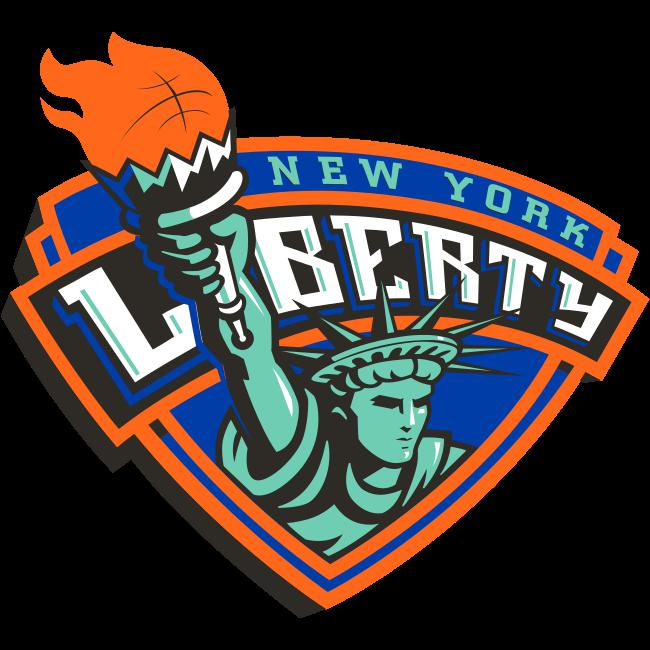
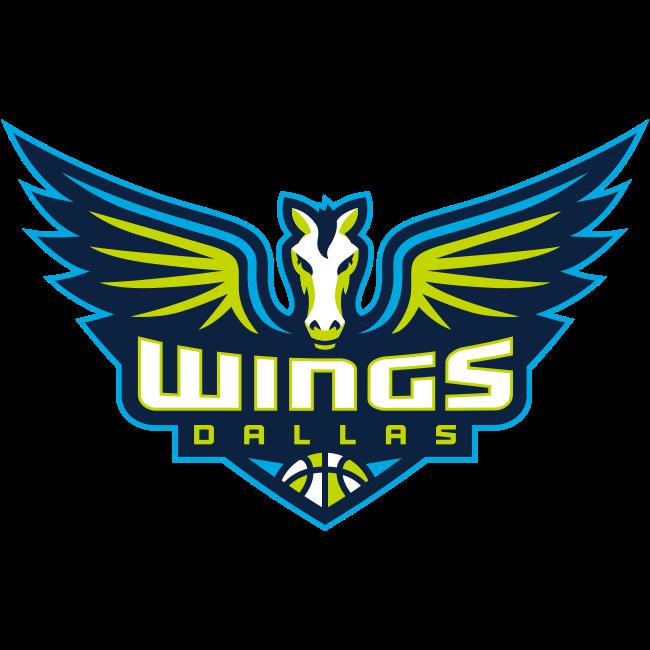
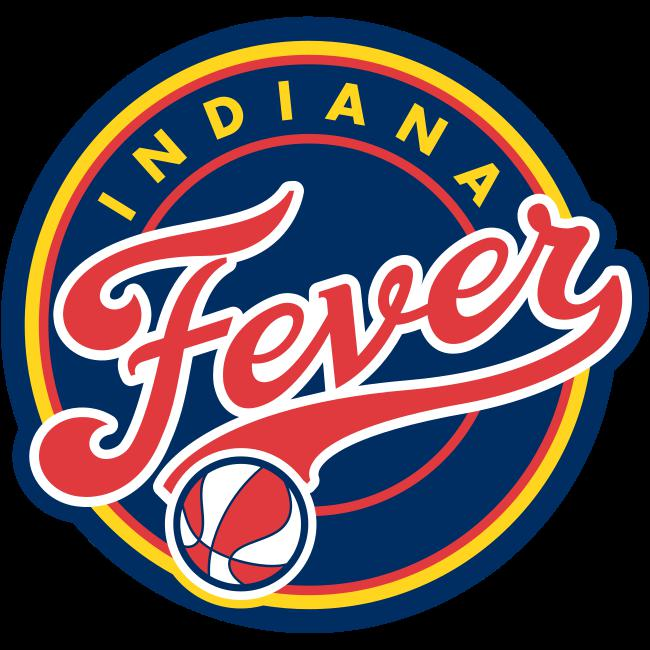
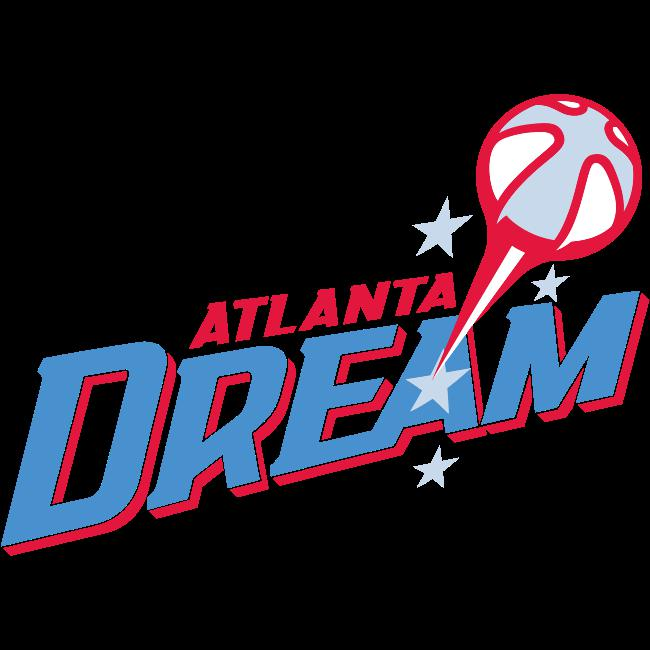

In [69]:
HTML(lotto_df.to_html(formatters={'logo': image_formatter}, escape=False))

## Conclusion

Be sure to run this notebook live as the draft order is being revealed!